In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
G=ox.graph_from_place("Nakagawa-ku,Nagoya,Japan",network_type='drive')

In [3]:
nodes,edges=ox.graph_to_gdfs(G)

In [4]:
invalid_cols=['osmid','highway','bridge','lanes','ref','name']
edges[invalid_cols] = edges[invalid_cols].astype(str)

In [5]:
edges['highway'].unique()

array(['residential', 'motorway', 'motorway_link', 'unclassified',
       'trunk', 'secondary', 'tertiary', 'primary',
       "['residential', 'unclassified']", "['unclassified', 'tertiary']",
       'primary_link', 'trunk_link', "['residential', 'tertiary']"],
      dtype=object)

In [6]:
edges["maxspeed"].value_counts(dropna=False)

NaN    22354
40       140
30        20
60         6
Name: maxspeed, dtype: int64

In [7]:
edges['highway'].value_counts()

unclassified                       15591
residential                         3041
tertiary                            2663
primary                              500
secondary                            407
trunk                                216
['residential', 'unclassified']       26
motorway_link                         23
primary_link                          16
motorway                              13
['unclassified', 'tertiary']          12
trunk_link                            10
['residential', 'tertiary']            2
Name: highway, dtype: int64

In [8]:
def road_class_to_kmph(road_class):
    if road_class=='residential':
        return 30
    elif road_class=='motorway':
        return 60
    elif road_class=='motorway_link':
        return 60
    elif road_class in ['trunk','trunk_link']:
        return 60
    elif road_class=='secondary':
        return 50
    elif road_class=='tertiary':
        return 40
    elif road_class in ['primary','primary_link']:
        return 50
    elif road_class==['tertiary', 'residential']:
        return 40
    elif road_class==['unclassified', 'residential']:
        return 30
    else :
        return 30

In [9]:
edges["maxspeed"] = edges["maxspeed"].astype(float).astype(pd.Int64Dtype())
edges["maxspeed"].unique()

<IntegerArray>
[<NA>, 30, 40, 60]
Length: 4, dtype: Int64

In [10]:
# Separate rows with / without speed limit information 
mask = edges["maxspeed"].isnull()
edges_without_maxspeed = edges.loc[mask].copy()
edges_with_maxspeed = edges.loc[~mask].copy()

# Apply the function and update the maxspeed
edges_without_maxspeed["maxspeed"] = edges_without_maxspeed["highway"].apply(road_class_to_kmph)
edges_without_maxspeed.head(5).loc[:, ["maxspeed", "highway"]]

maxspeed        highway
u         v          key                         
265835867 1583801850 0          30    residential
287037206 6418759114 0          60       motorway
          8687399278 0          60  motorway_link
287051498 1161617447 0          30   unclassified
          3909362365 0          60          trunk

In [11]:
edges = edges_with_maxspeed.append(edges_without_maxspeed)
edges["maxspeed"].unique()

<IntegerArray>
[30, 40, 60, 50]
Length: 4, dtype: Int64

In [12]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'length', 'bridge', 'lanes', 'ref',
       'name', 'geometry', 'est_width', 'maxspeed', 'tunnel'],
      dtype='object')

In [13]:
edges.est_width.value_counts()

13.0m以上       4
5.5m〜13.0m    3
Name: est_width, dtype: int64

In [14]:
edges.head(6)

osmid      highway  oneway   length bridge  \
u         v          key                                                   
495060600 660711475  0     55824264  residential   False   44.513    nan   
495060608 660711366  0     47119686     tertiary   False  153.752    nan   
628595857 660917848  0     49478329     tertiary   False  156.572    nan   
628595860 712559797  0    318778964     tertiary   False  185.640    nan   
628595863 1547522057 0     49478329     tertiary   False  145.366    nan   
          660917860  0     49478329     tertiary   False   62.751    nan   

                         lanes  ref name  \
u         v          key                   
495060600 660711475  0       2  nan  nan   
495060608 660711366  0       2  nan  nan   
628595857 660917848  0       1  nan  nan   
628595860 712559797  0       1  nan  nan   
628595863 1547522057 0       1  nan  nan   
          660917860  0       1  nan  nan   

                                                                   geometry  \
u         v          key                                                      
495060600 660711475  0    LINESTRING (136.89193 35.15705, 136.89145 35.1...   
495060608 660711366  0    LINESTRING (136.89232 35.15392, 136.89063 35.1...   
628595857 660917848  0    LINESTRING (136.89463 35.14493, 136.89509 35.1...   
628595860 712559797  0    LINESTRING (136.89656 35.13999, 136.89691 35.1...   
628595863 1547522057 0    LINESTRING (136.89539 35.14256, 136.89542 35.1...   
          660917860  0    LINESTRING (136.89539 35.14256, 136.89536 35.1...   

                         est_width  maxspeed tunnel  
u         v          key                             
495060600 660711475  0         NaN        30    NaN  
495060608 660711366  0         NaN        40    NaN  
628595857 660917848  0         NaN        40    NaN  
628595860 712559797  0         NaN        40    NaN  
628595863 1547522057 0         NaN        40    NaN  
          660917860  0         NaN        40    NaN

<AxesSubplot:>

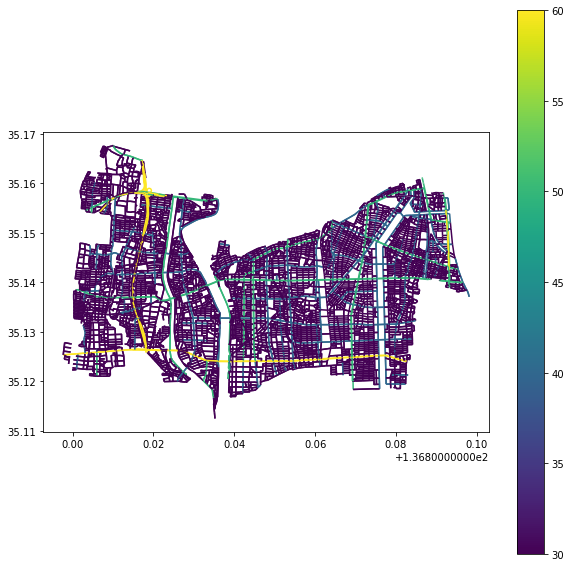

In [15]:
edges["maxspeed"] = edges["maxspeed"].astype(int)
edges.plot(column="maxspeed", figsize=(10,10), legend=True)

In [16]:
len(edges)

22520

In [17]:
# Distance risk
graph_distance = nx.read_gpickle("data/nakagawa_graph_distance_risk_added.pickle")
_,edges_distance = ox.graph_to_gdfs(graph_distance)

In [18]:
len(edges_distance)

30694

In [19]:
# Building risk
graph_building = nx.read_gpickle("data/nakagawa_graph_building_density_risk_addded.pickle")
_,edges_building = ox.graph_to_gdfs(graph_building)

In [20]:
len(edges_building)

30694

In [21]:
# Earthquake risk
graph_earthquake = nx.read_gpickle("data/nakagawa_graph_earthquake_risk_addded.pickle")
_,edges_earthquake = ox.graph_to_gdfs(graph_earthquake)

In [22]:
len(edges_earthquake)

41756

In [20]:
edges_distance.head()

osmid  \
u          v          key                                                 
287037206  6418759114 0                          [235402848, 940877736]   
           8687399278 0    [937718833, 940585691, 766866772, 766866773]   
8687399278 7162166992 0                                       766866776   
287051498  1161617447 0                                       140501318   
           3909362365 0                                       311076737   

                                   bridge  oneway lanes       ref  \
u          v          key                                           
287037206  6418759114 0    [viaduct, yes]    True     2  [5, E23]   
           8687399278 0               yes    True   NaN       NaN   
8687399278 7162166992 0               yes    True   NaN       NaN   
287051498  1161617447 0               NaN   False   NaN       NaN   
           3909362365 0               NaN    True     2         1   

                                            name        highway   length  \
u          v          key                                                  
287037206  6418759114 0    [名古屋高速5号万場線, 東名阪自動車道]       motorway  549.217   
           8687399278 0              名古屋第二環状自動車道  motorway_link  717.481   
8687399278 7162166992 0              名古屋第二環状自動車道  motorway_link  211.954   
287051498  1161617447 0                      NaN   unclassified   12.298   
           3909362365 0                     国道1号          trunk  106.927   

                                                                    geometry  \
u          v          key                                                      
287037206  6418759114 0    LINESTRING (136.81737 35.15822, 136.81780 35.1...   
           8687399278 0    LINESTRING (136.81737 35.15822, 136.81817 35.1...   
8687399278 7162166992 0    LINESTRING (136.81880 35.15551, 136.81879 35.1...   
287051498  1161617447 0    LINESTRING (136.84672 35.12402, 136.84672 35.1...   
           3909362365 0    LINESTRING (136.84672 35.12402, 136.84555 35.1...   

                           sampling_counts  ...  median_scaled  \
u          v          key                   ...                  
287037206  6418759114 0                 50  ...       1.648721   
           8687399278 0                 50  ...       1.648721   
8687399278 7162166992 0                 50  ...       2.718282   
287051498  1161617447 0                 50  ...       1.648721   
           3909362365 0                 50  ...       1.648721   

                           mean_scaled_inversed  median_scaled_inversed  \
u          v          key                                                 
287037206  6418759114 0              146.747868              146.764438   
           8687399278 0              146.697152              146.764438   
8687399278 7162166992 0              145.775215              145.694877   
287051498  1161617447 0              146.764438              146.764438   
           3909362365 0              146.714227              146.764438   

                           distance_risk_score edge_color est_width  tunnel  \
u          v          key                                                     
287037206  6418759114 0                    8.0        red       NaN     NaN   
           8687399278 0                    6.0     yellow       NaN     NaN   
8687399278 7162166992 0                    8.0        red       NaN     NaN   
287051498  1161617447 0                    9.0        red       NaN     NaN   
           3909362365 0                    8.0        red       NaN     NaN   

                           service  maxspeed  width  
u          v          key                            
287037206  6418759114 0        NaN       NaN    NaN  
           8687399278 0        NaN       NaN    NaN  
8687399278 7162166992 0        NaN       NaN    NaN  
287051498  1161617447 0        NaN       NaN    NaN  
           3909362365 0        NaN       NaN    NaN  

[5 rows x 27 columns]

In [21]:
edges_building.head()

osmid  \
u          v          key                                                 
287037206  6418759114 0                          [235402848, 940877736]   
           8687399278 0    [937718833, 940585691, 766866772, 766866773]   
8687399278 7162166992 0                                       766866776   
287051498  1161617447 0                                       140501318   
           3909362365 0                                       311076737   

                                   bridge  oneway lanes       ref  \
u          v          key                                           
287037206  6418759114 0    [viaduct, yes]    True     2  [5, E23]   
           8687399278 0               yes    True   NaN       NaN   
8687399278 7162166992 0               yes    True   NaN       NaN   
287051498  1161617447 0               NaN   False   NaN       NaN   
           3909362365 0               NaN    True     2         1   

                                            name        highway   length  \
u          v          key                                                  
287037206  6418759114 0    [東名阪自動車道, 名古屋高速5号万場線]       motorway  549.217   
           8687399278 0              名古屋第二環状自動車道  motorway_link  717.481   
8687399278 7162166992 0              名古屋第二環状自動車道  motorway_link  211.954   
287051498  1161617447 0                      NaN   unclassified   12.298   
           3909362365 0                     国道1号          trunk  106.927   

                                                                    geometry  \
u          v          key                                                      
287037206  6418759114 0    LINESTRING (136.81737 35.15822, 136.81780 35.1...   
           8687399278 0    LINESTRING (136.81737 35.15822, 136.81817 35.1...   
8687399278 7162166992 0    LINESTRING (136.81880 35.15551, 136.81879 35.1...   
287051498  1161617447 0    LINESTRING (136.84672 35.12402, 136.84672 35.1...   
           3909362365 0    LINESTRING (136.84672 35.12402, 136.84555 35.1...   

                           building_count est_width tunnel service maxspeed  \
u          v          key                                                     
287037206  6418759114 0               215       NaN    NaN     NaN      NaN   
           8687399278 0               215       NaN    NaN     NaN      NaN   
8687399278 7162166992 0               467       NaN    NaN     NaN      NaN   
287051498  1161617447 0               311       NaN    NaN     NaN      NaN   
           3909362365 0               311       NaN    NaN     NaN      NaN   

                          width  
u          v          key        
287037206  6418759114 0     NaN  
           8687399278 0     NaN  
8687399278 7162166992 0     NaN  
287051498  1161617447 0     NaN  
           3909362365 0     NaN

In [22]:
edges_earthquake.head()

osmid       highway  oneway   length  \
u          v          key                                             
265835867  1583801850 0    891546719   residential   False  123.257   
1583801850 1583801736 0    144896104  unclassified   False   60.260   
           1583801938 0    144898376  unclassified   False   57.588   
           265835867  0    891546719   residential   False  123.257   
           1583801828 0    144898782  unclassified   False  116.876   

                                                                    geometry  \
u          v          key                                                      
265835867  1583801850 0    LINESTRING (136.80442 35.14114, 136.80578 35.1...   
1583801850 1583801736 0    LINESTRING (136.80578 35.14108, 136.80574 35.1...   
           1583801938 0    LINESTRING (136.80578 35.14108, 136.80581 35.1...   
           265835867  0    LINESTRING (136.80578 35.14108, 136.80442 35.1...   
           1583801828 0    LINESTRING (136.80578 35.14108, 136.80701 35.1...   

                           earthquake_risk bridge lanes  ref name width  \
u          v          key                                                 
265835867  1583801850 0                6.5    NaN   NaN  NaN  NaN   NaN   
1583801850 1583801736 0                6.5    NaN   NaN  NaN  NaN   NaN   
           1583801938 0                6.5    NaN   NaN  NaN  NaN   NaN   
           265835867  0                6.5    NaN   NaN  NaN  NaN   NaN   
           1583801828 0                6.5    NaN   NaN  NaN  NaN   NaN   

                          maxspeed est_width tunnel  
u          v          key                            
265835867  1583801850 0        NaN       NaN    NaN  
1583801850 1583801736 0        NaN       NaN    NaN  
           1583801938 0        NaN       NaN    NaN  
           265835867  0        NaN       NaN    NaN  
           1583801828 0        NaN       NaN    NaN

In [23]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
edges_distance.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
edges['uv']=edges.index.to_numpy()

In [24]:
edges.head()

,,,osmid,highway,oneway,length,bridge,lanes,ref,name,geometry,est_width,maxspeed,tunnel,uv
u,v,key,,,,,,,,,,,,,
495060600,660711475,0,55824264,residential,False,44.513,nan,2,nan,nan,"LINESTRING (136.89193 35.15705, 136.89145 35.1...",NaN,30,NaN,"(495060600, 660711475, 0)"
495060608,660711366,0,47119686,tertiary,False,153.752,nan,2,nan,nan,"LINESTRING (136.89232 35.15392, 136.89063 35.1...",NaN,40,NaN,"(495060608, 660711366, 0)"
628595857,660917848,0,49478329,tertiary,False,156.572,nan,1,nan,nan,"LINESTRING (136.89463 35.14493, 136.89509 35.1...",NaN,40,NaN,"(628595857, 660917848, 0)"
628595860,712559797,0,318778964,tertiary,False,185.640,nan,1,nan,nan,"LINESTRING (136.89656 35.13999, 136.89691 35.1...",NaN,40,NaN,"(628595860, 712559797, 0)"
628595863,1547522057,0,49478329,tertiary,False,145.366,nan,1,nan,nan,"LINESTRING (136.89539 35.14256, 136.89542 35.1...",NaN,40,NaN,"(628595863, 1547522057, 0)"


In [34]:
combine_score=pd.merge(edges_distance,edges_building,how="inner",on='geometry')

In [35]:
len(combine_score)

30718

In [37]:
combine_score.columns

Index(['osmid_x', 'bridge_x', 'oneway_x', 'lanes_x', 'ref_x', 'name_x',
       'highway_x', 'length_x', 'geometry', 'sampling_counts', 'max', 'min',
       'mean', 'median', 'x_y', 'lon_lat', 'mean_scaled', 'median_scaled',
       'mean_scaled_inversed', 'median_scaled_inversed', 'distance_risk_score',
       'edge_color', 'est_width_x', 'tunnel_x', 'service_x', 'maxspeed_x',
       'width_x', 'osmid_y', 'bridge_y', 'oneway_y', 'lanes_y', 'ref_y',
       'name_y', 'highway_y', 'length_y', 'building_count', 'est_width_y',
       'tunnel_y', 'service_y', 'maxspeed_y', 'width_y'],
      dtype='object')

In [41]:
combine_score=combine_score.loc[:,['osmid_x', 'bridge_x', 'oneway_x', 'lanes_x', 'ref_x', 'name_x',
       'highway_x', 'length_x', 'geometry','distance_risk_score','building_count']]

In [42]:
combine_score=pd.merge(combine_score,edges_earthquake,how="inner",on='geometry')

In [44]:
len(combine_score)

20040

In [43]:
combine_score.columns

Index(['osmid_x', 'bridge_x', 'oneway_x', 'lanes_x', 'ref_x', 'name_x',
       'highway_x', 'length_x', 'geometry', 'distance_risk_score',
       'building_count', 'osmid', 'highway', 'oneway', 'length',
       'earthquake_risk', 'bridge', 'lanes', 'ref', 'name', 'width',
       'maxspeed', 'est_width', 'tunnel'],
      dtype='object')

In [45]:
combine_score=combine_score.loc[:,['osmid_x', 'bridge_x', 'oneway_x', 'lanes_x', 'ref_x', 'name_x',
       'highway_x', 'length_x', 'geometry', 'distance_risk_score',
       'building_count', 'earthquake_risk']]

In [46]:
combine_score=pd.merge(combine_score,edges,how="inner",on='geometry')

In [47]:
len(combine_score)

20092

In [48]:
combine_score.columns

Index(['osmid_x', 'bridge_x', 'oneway_x', 'lanes_x', 'ref_x', 'name_x',
       'highway_x', 'length_x', 'geometry', 'distance_risk_score',
       'building_count', 'earthquake_risk', 'osmid', 'highway', 'oneway',
       'length', 'bridge', 'lanes', 'ref', 'name', 'est_width', 'maxspeed',
       'tunnel', 'uv'],
      dtype='object')

In [49]:
combine_score.index=pd.MultiIndex.from_tuples(combine_score.uv, names=('u', 'v','key'))

In [50]:
combine_score.head(5)

osmid_x  \
u          v          key                                                 
287037206  6418759114 0                          [235402848, 940877736]   
           8687399278 0    [937718833, 940585691, 766866772, 766866773]   
8687399278 7162166992 0                                       766866776   
287051498  1161617447 0                                       140501318   
           3909362365 0                                       311076737   

                                 bridge_x  oneway_x lanes_x     ref_x  \
u          v          key                                               
287037206  6418759114 0    [viaduct, yes]      True       2  [5, E23]   
           8687399278 0               yes      True     NaN       NaN   
8687399278 7162166992 0               yes      True     NaN       NaN   
287051498  1161617447 0               NaN     False     NaN       NaN   
           3909362365 0               NaN      True       2         1   

                                          name_x      highway_x  length_x  \
u          v          key                                                   
287037206  6418759114 0    [名古屋高速5号万場線, 東名阪自動車道]       motorway   549.217   
           8687399278 0              名古屋第二環状自動車道  motorway_link   717.481   
8687399278 7162166992 0              名古屋第二環状自動車道  motorway_link   211.954   
287051498  1161617447 0                      NaN   unclassified    12.298   
           3909362365 0                     国道1号          trunk   106.927   

                                                                    geometry  \
u          v          key                                                      
287037206  6418759114 0    LINESTRING (136.81737 35.15822, 136.81780 35.1...   
           8687399278 0    LINESTRING (136.81737 35.15822, 136.81817 35.1...   
8687399278 7162166992 0    LINESTRING (136.81880 35.15551, 136.81879 35.1...   
287051498  1161617447 0    LINESTRING (136.84672 35.12402, 136.84672 35.1...   
           3909362365 0    LINESTRING (136.84672 35.12402, 136.84555 35.1...   

                           distance_risk_score  ...  oneway   length  \
u          v          key                       ...                    
287037206  6418759114 0                    8.0  ...    True  549.217   
           8687399278 0                    6.0  ...    True  717.481   
8687399278 7162166992 0                    8.0  ...    True  211.954   
287051498  1161617447 0                    9.0  ...   False   12.298   
           3909362365 0                    8.0  ...    True  106.927   

                                       bridge lanes           ref  \
u          v          key                                           
287037206  6418759114 0    ['yes', 'viaduct']     2  ['E23', '5']   
           8687399278 0                   yes   nan           nan   
8687399278 7162166992 0                   yes   nan           nan   
287051498  1161617447 0                   nan   nan           nan   
           3909362365 0                   nan     2             1   

                                                name est_width maxspeed  \
u          v          key                                                 
287037206  6418759114 0    ['東名阪自動車道', '名古屋高速5号万場線']       NaN       60   
           8687399278 0                  名古屋第二環状自動車道       NaN       60   
8687399278 7162166992 0                  名古屋第二環状自動車道       NaN       60   
287051498  1161617447 0                          nan       NaN       30   
           3909362365 0                         国道1号       NaN       60   

                          tunnel                           uv  
u          v          key                                      
287037206  6418759114 0      NaN   (287037206, 6418759114, 0)  
           8687399278 0      NaN   (287037206, 8687399278, 0)  
8687399278 7162166992 0      NaN  (8687399278, 7162166992, 0)  
287051498  1161617447 0      NaN   (287051498, 1161617447, 0)  
           3909362365 0   

In [52]:
combine_score=combine_score.loc[:,['osmid', 'highway', 'oneway',
         'length', 'bridge', 'lanes', 'ref', 'name', 'est_width', 'maxspeed',
          'tunnel', 'distance_risk_score',
         'building_count', 'earthquake_risk','geometry']]

In [56]:
len(combine_score)

20092

In [58]:
combineG=ox.utils_graph.graph_from_gdfs(nodes,combine_score, graph_attrs=None)

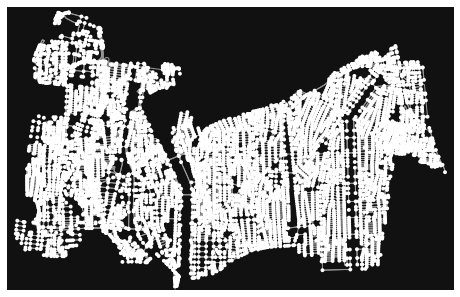

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [59]:
ox.plot_graph(combineG)

In [61]:
nx.write_gpickle(combineG, "data/combined_score_addded.pickle")